# Spotify Song Skipping Prediction Part I




## Dependencies



In [4]:
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, Dropdown

In [5]:
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
%matplotlib inline

rc('text', usetex=False)
#matplotlib.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [6]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng --fix-missing

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-adf-accanthis fonts-adf-berenis fonts-adf-gillius
  fonts-adf-universalis fonts-cabin fonts-cantarell fonts-comfortaa fonts-croscore
  fonts-crosextra-caladea fonts-crosextra-carlito fonts-dejavu-core fonts-dejavu-extra
  fonts-droid-fallback fonts-ebgaramond fonts-ebgaramond-extra fonts-font-awesome
  fonts-freefont-otf fonts-freefont-ttf fonts-gfs-artemisia fonts-gfs-complutum fonts-gfs-didot
  fonts-gfs-neohellenic fonts-gfs-olga fonts-gfs-solomos fonts-go fonts-junicode fonts-lato
  fonts-linuxlibertine fonts-lmodern fonts-lobster fonts-lobstertwo fonts-noto-color-emoji
  fonts-noto-core fonts-noto-mono fonts-oflb-asana-math fonts-open-sans fonts-roboto-unhinted
  fonts-sil-charis fonts-sil-gentium fonts-sil-gentium-basic fonts-sil-gentiumplus
  fonts-sil-gentiumplus-compact fonts-stix fonts-texgyre fo

In [7]:
! sudo apt-get install texlive-latex-recommended #1
! sudo apt-get install dvipng texlive-fonts-recommended #2
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip #3
! unzip type1cm.zip -d /tmp/type1cm #4
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins  #5
! sudo mkdir /usr/share/texmf/tex/latex/type1cm #6
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm #7
! sudo texhash #8

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
texlive-latex-recommended is already the newest version (2021.20220204-1).
texlive-latex-recommended set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
dvipng is already the newest version (1.15-1.1).
texlive-fonts-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
--2023-11-05 04:40:17--  http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
Resolving mirrors.ctan.org (mirrors.ctan.org)... 89.58.7.101
Connecting to mirrors.ctan.org (mirrors.ctan.org)|89.58.7.101|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mirror.mwt.me/ctan/macros/latex/contrib/type1cm.zip [following]
--2023-11-05 04:40:18--  https://mirror.mwt.me/ctan/macros/latex/contri

## Getting data from AIcrowd

In [8]:
!pip install -U aicrowd-cli==0.1 > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
flask 2.2.5 requires click>=8.0, but you have click 7.1.2 which is incompatible.
dask 2023.8.1 requires click>=8.0, but you have click 7.1.2 which is incompatible.
distributed 2023.8.1 requires click>=8.0, but you have click 7.1.2 which is incompatible.
fiona 1.9.5 requires click~=8.0, but you have click 7.1.2 which is incompatible.
pip-tools 6.13.0 requires click>=8, but you have click 7.1.2 which is incompatible.


In [9]:
API_KEY = "7865a042cef916d916af00b218941208"
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [10]:
!aicrowd dataset list --challenge spotify-sequential-skip-prediction-challenge

                                    Datasets for challenge #204                                     
┌───┬──────────────────────────────────────┬───────────────────────────────────────────┬───────────┐
│ # │ Title                                │ Description                               │      Size │
├───┼──────────────────────────────────────┼───────────────────────────────────────────┼───────────┤
│ 0 │ Dataset Description                  │ Description of fields for dataset tables  │ 176.25 KB │
│ 1 │ Sample_Submissions.tar.gz            │ Sample Submission                         │       86M │
│ 2 │ Terms and Conditions                 │ Terms and Conditions                      │       61K │
│ 3 │ Test_Set.tar.gz                      │ Test Set                                  │       14G │
│ 4 │ Track_Features.tar.gz                │ Track Features                            │      1.2G │
│ 5 │ Training_Set_And_Track_Features_Mini │ Minimally sized version of training set   │  1

In [11]:
!aicrowd dataset download --challenge spotify-sequential-skip-prediction-challenge 7

20181113_training_set.tar.gz: 100% 60.4G/60.4G [26:10<00:00, 38.5MB/s]


In [12]:
!tar -xzvf "/content/20181113_training_set.tar.gz"

training_set/
training_set/log_0_20180815_000000000000.csv
training_set/log_5_20180809_000000000000.csv
training_set/log_9_20180820_000000000000.csv
training_set/log_4_20180719_000000000000.csv
training_set/log_2_20180908_000000000000.csv
training_set/log_4_20180816_000000000000.csv
training_set/log_3_20180829_000000000000.csv
training_set/log_1_20180802_000000000000.csv
training_set/log_7_20180730_000000000000.csv
training_set/log_0_20180829_000000000000.csv
training_set/log_5_20180726_000000000000.csv
^C


## Loading the data


In [14]:
# Audio features of songs
track_features_1 = pd.read_csv('/content/tf_000000000000.csv',
                               encoding= 'unicode_escape', low_memory=False)
track_features_2 = pd.read_csv('/content/tf_000000000001.csv',
                               encoding= 'unicode_escape', low_memory=False)
track_features = pd.concat([track_features_1, track_features_2], ignore_index=True)

In [17]:
print('Number of unique songs: {}'.format(len(track_features)))

Number of unique songs: 3708288


In [16]:
# Spotify streaming session data
data = pd.read_csv('/content/training_set/log_0_20180815_000000000000.csv')

In [18]:
# Check that all songs in the streaming data exist in the audio features data
set(data.track_id_clean).issubset(set(track_features.track_id))

True

In [19]:
data.head(3)

,session_id,session_position,session_length,track_id_clean,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,hour_of_day,date,premium,context_type,hist_user_behavior_reason_start,hist_user_behavior_reason_end
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,...,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,...,1,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,...,0,0,0,True,8,2018-08-14,True,user_collection,fwdbtn,fwdbtn


In [20]:
data.columns

Index(['session_id', 'session_position', 'session_length', 'track_id_clean',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end'],
      dtype='object')

In [21]:
track_features.columns

Index(['track_id', 'duration', 'release_year', 'us_popularity_estimate',
       'acousticness', 'beat_strength', 'bounciness', 'danceability',
       'dyn_range_mean', 'energy', 'flatness', 'instrumentalness', 'key',
       'liveness', 'loudness', 'mechanism', 'mode', 'organism', 'speechiness',
       'tempo', 'time_signature', 'valence', 'acoustic_vector_0',
       'acoustic_vector_1', 'acoustic_vector_2', 'acoustic_vector_3',
       'acoustic_vector_4', 'acoustic_vector_5', 'acoustic_vector_6',
       'acoustic_vector_7'],
      dtype='object')

In [22]:
# Merge the streaming data with the audio features data
data = data.rename(columns={'track_id_clean': 'track_id'})

df = data.merge(track_features, how='left', on='track_id')
df['mode'] = df['mode'].map({'major': 1, 'minor': 0})

df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'],
      dtype='object

In [23]:
# Checking for missing values
df.isna().sum()

session_id                         0
session_position                   0
session_length                     0
track_id                           0
skip_1                             0
skip_2                             0
skip_3                             0
not_skipped                        0
context_switch                     0
no_pause_before_play               0
short_pause_before_play            0
long_pause_before_play             0
hist_user_behavior_n_seekfwd       0
hist_user_behavior_n_seekback      0
hist_user_behavior_is_shuffle      0
hour_of_day                        0
date                               0
premium                            0
context_type                       0
hist_user_behavior_reason_start    0
hist_user_behavior_reason_end      0
duration                           0
release_year                       0
us_popularity_estimate             0
acousticness                       0
beat_strength                      0
bounciness                         0
d

In [24]:
df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7'],
      dtype='object

## EDA & Feature Engineering

interactive(children=(Dropdown(description='Variable', index=25, options=('session_id', 'session_position', 's…

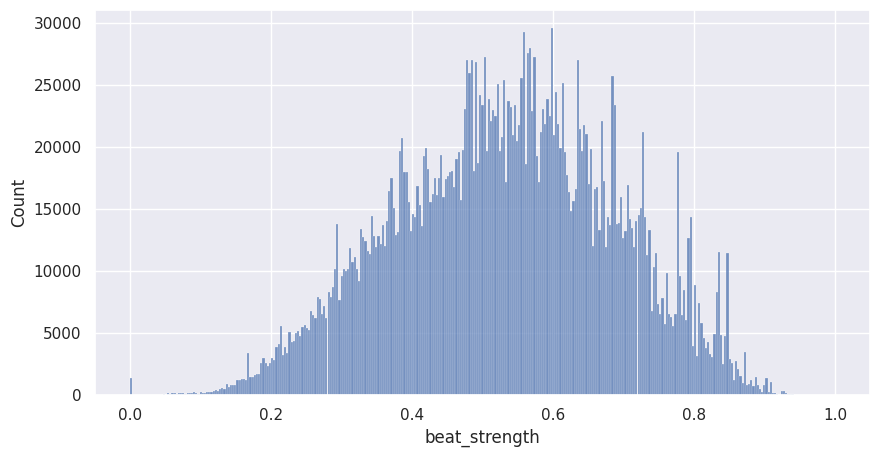

In [25]:
# Function to generate histograms [Dropdown]
var_name = Dropdown(options=df.columns, value='beat_strength')

@interact(Variable = var_name)
def plotting(Variable):
    plt.figure(figsize=(10, 5))
    sns.histplot(df[Variable])

In [26]:
# Count of skipped songs
df.not_skipped.value_counts()

False    2022052
True     1084136
Name: not_skipped, dtype: int64

In [27]:
# Number of sessions in the data
df.session_id.nunique()

188450

In [28]:
sub_data = df.groupby('not_skipped', group_keys=False).apply(lambda x: x.sample(1000000))

sub_data.not_skipped.value_counts()

False    1000000
True     1000000
Name: not_skipped, dtype: int64

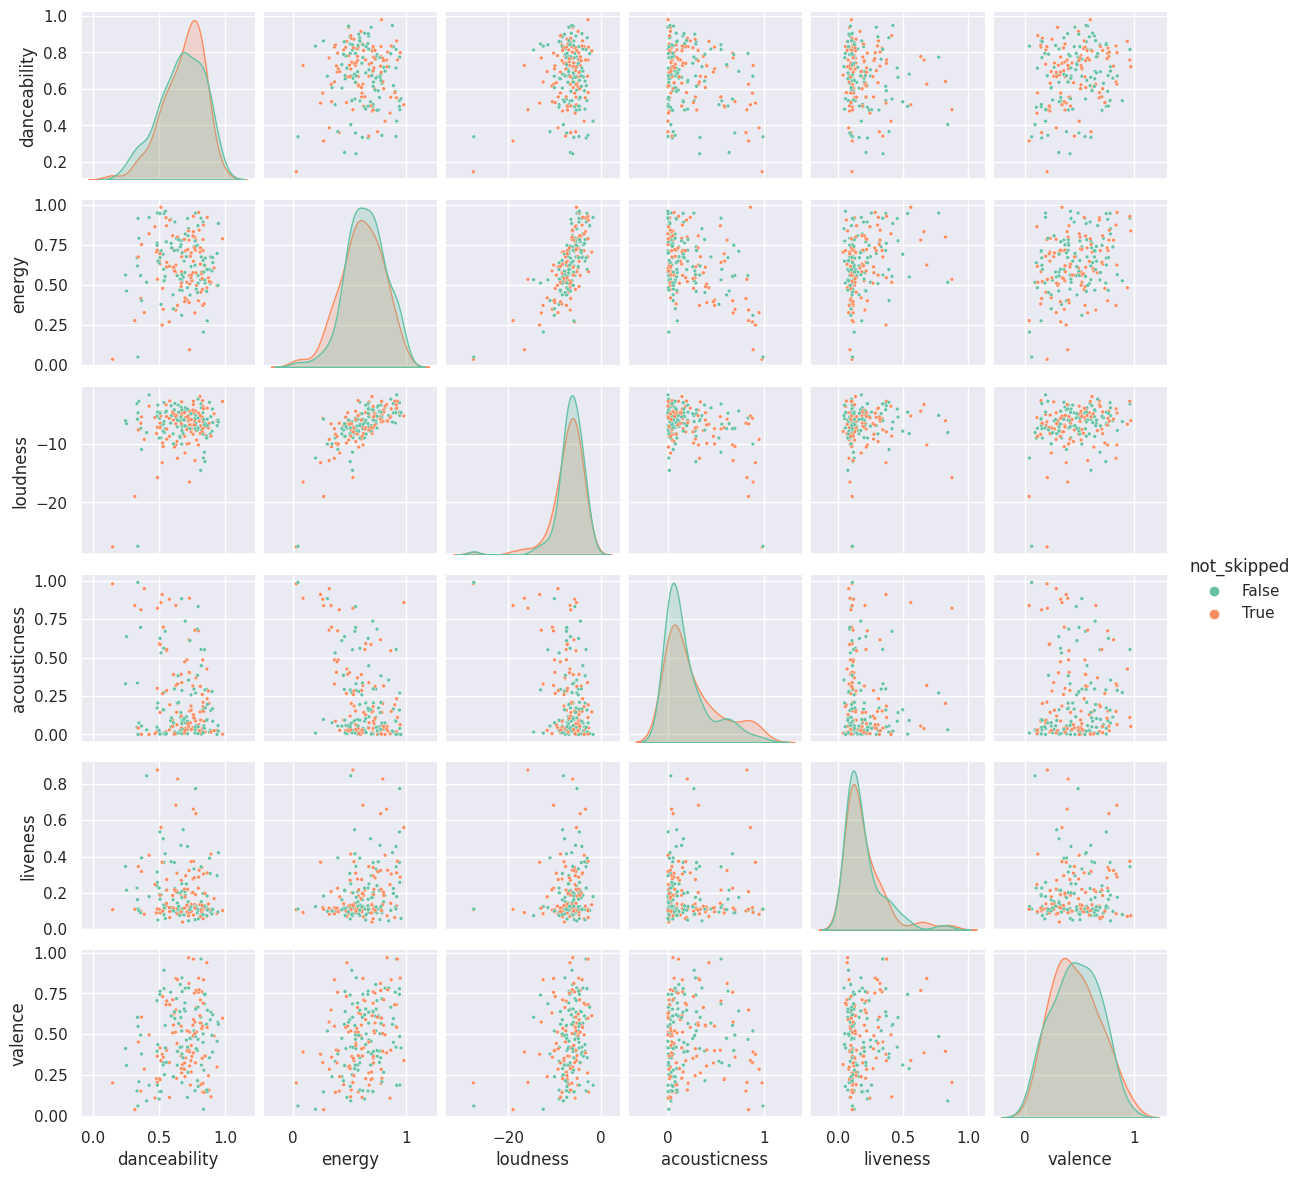

In [29]:
# Audio features coded by whether the song was skipped or not
'''
Audio features of skipped and non-skipped songs
When predicting song skipping solely based on audio features, we need to create a boundary that
separates the two labels for each of the audio features.
Type of questions that can be asked:
  - Are there any values of audio features where songs are mostly skipped? (e.g., if a song has less than -30 in loudness)
  - Is there a combination of the audio features that are mostly skipped? Can artists capitalize on that information?
'''

audio_features = ['danceability', 'energy', 'loudness', 'acousticness', 'liveness', 'valence', 'not_skipped']
sns.pairplot(data=sub_data.sample(frac=.0001, replace=False, random_state=7)[audio_features],
             hue='not_skipped', palette='Set2', height=2, plot_kws={"s":7});

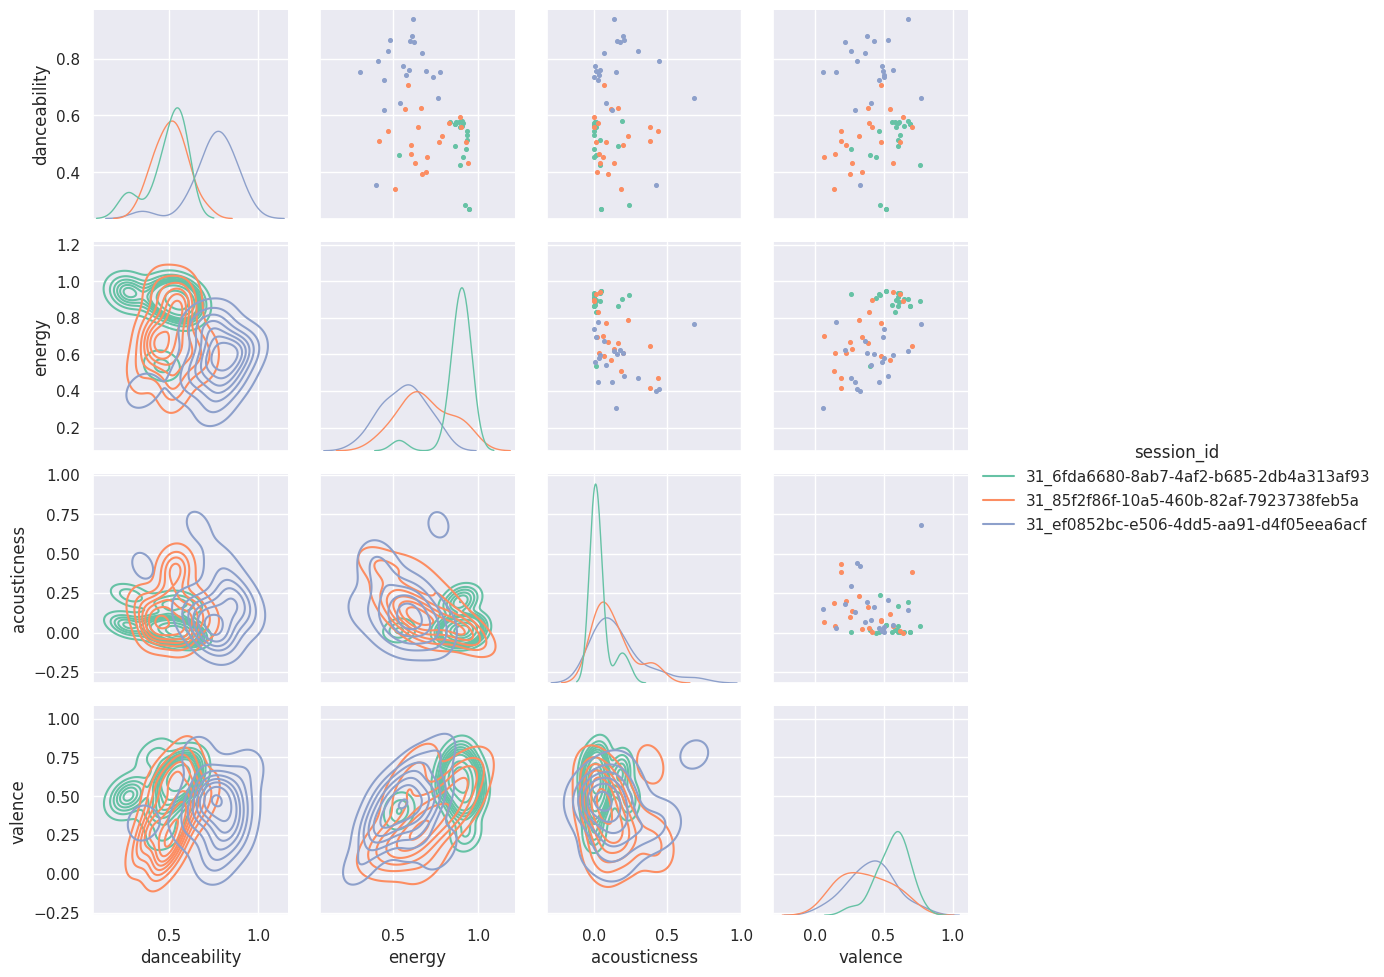

In [30]:
# Audio features of several streaming sessions

'''
Type of questions that can be asked:
  - Are streaming sessions homogenous in terms of audio characteristics?
  - Does it make sense to try clustering songs?
'''


random_sessions = np.random.choice(df.session_id.unique(), 3)
#df.session_id.unique()[64:68]

features = ['danceability', 'energy', 'acousticness', 'valence', 'session_id']
g = sns.PairGrid(df[df.session_id.isin(random_sessions)][features], hue='session_id', palette='Set2')
g.map_upper(plt.scatter, s=7)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=1)
g.add_legend();

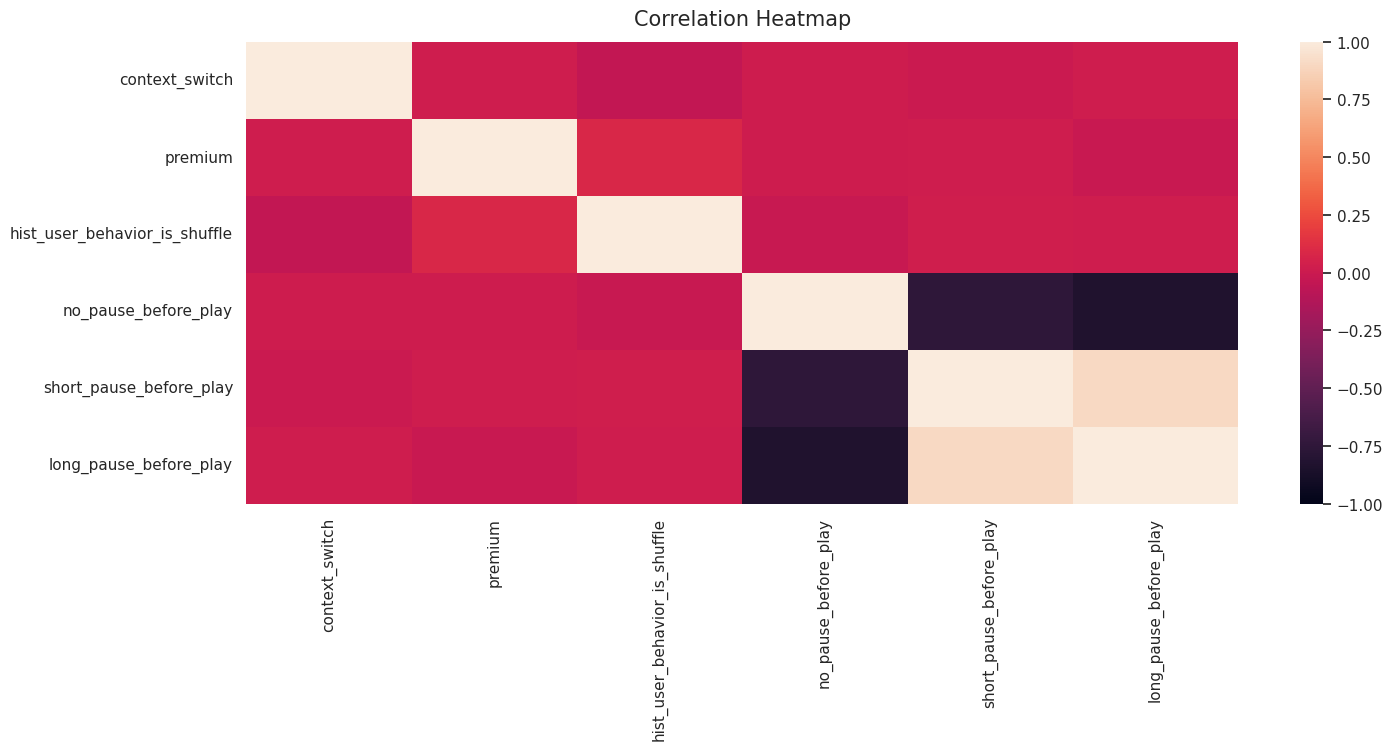

In [31]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df[['context_switch', 'premium',
                'hist_user_behavior_is_shuffle',
                'no_pause_before_play',
                'short_pause_before_play',
                'long_pause_before_play']].corr(), vmin=-1, vmax=1, annot=False);
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12);

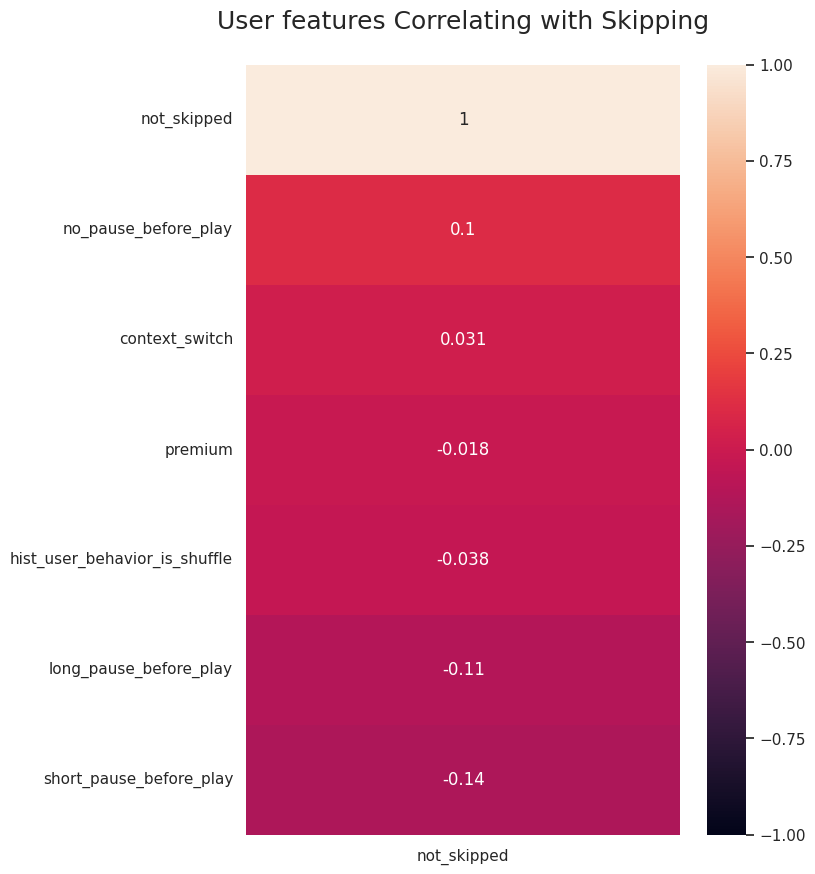

In [32]:
#plt.rcParams["font.family"] = ""
plt.figure(figsize=(7, 10))
heatmap = sns.heatmap(df[['not_skipped',
                          'context_switch',
                          'premium',
                          'hist_user_behavior_is_shuffle',
                          'no_pause_before_play',
                          'short_pause_before_play',
                          'long_pause_before_play']].corr()[['not_skipped']].sort_values(by='not_skipped', ascending=False),
                      vmin=-1, vmax=1, annot=True)
heatmap.set_title('User features Correlating with Skipping\n', fontdict={'fontsize':18, 'fontname':"Arial"});

In [33]:
# Skewness of us_popularity_estimates of skipped and not_skipped songs
# the data is negatively skewed (to the left), most songs are quite popular

df[df.not_skipped == True].us_popularity_estimate.skew()

-5.994593137513563

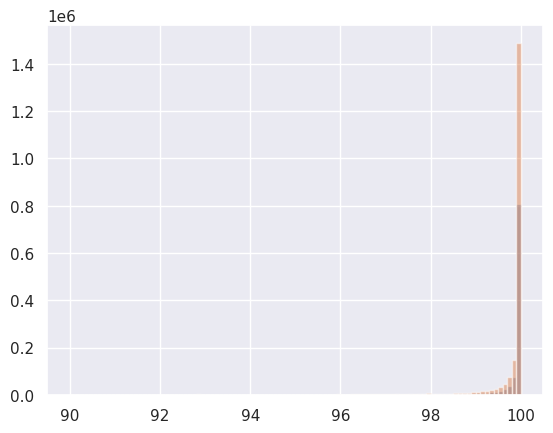

In [34]:
# How to deal with negatively skewed data? Log and Sqrt transformations didn't do much
plt.hist(df[df.not_skipped == True].us_popularity_estimate, bins=100, alpha=.5);
plt.hist(df[df.not_skipped == False].us_popularity_estimate, bins=100, alpha=.5);

In [35]:
df['date'] = pd.to_datetime(df['date'])

# Split the year, month, and day when the song was streaming
df["day"] = df['date'].map(lambda x: x.day)
df["month"] = df['date'].map(lambda x: x.month)
df["year"] = df['date'].map(lambda x: x.year)

In [36]:
# How come some people were listening to Spotify in 1969?
df.year.value_counts()

2018    3106085
2017         80
2016         13
2013         10
Name: year, dtype: int64

In [37]:
# Spotify started in 2008
df.drop(df[df.year < 2008].index, inplace=True)

In [38]:
df.release_year.value_counts()

2018.0    1108702
2017.0     650595
2016.0     318375
2015.0     198003
2014.0     108972
           ...   
1954.0        338
1950.0        231
1955.0        194
1953.0         91
1952.0         59
Name: release_year, Length: 69, dtype: int64

In [39]:
# Years since release: technically this number shouldn't be negative because you can't stream a song before it's released
df['years_since_release'] = df.year - df.release_year

# Dropping the songs that have a negative gap between streaming year and release year
df.drop(df[df.years_since_release < 0].index, inplace=True)

In [40]:
df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7', 'day',
       'month

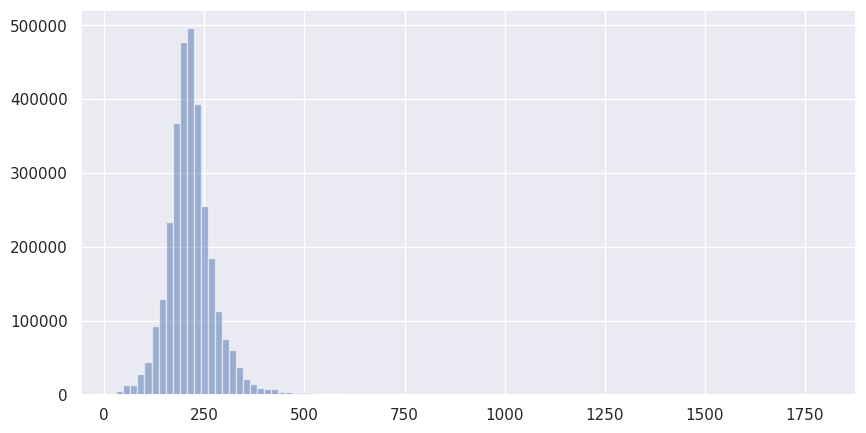

In [41]:
# Some features engineering
  # Time since the start of the session (or session position?) don't include session length and session position

# Distribution of song duration
plt.figure(figsize=(10, 5))
plt.hist(df.duration, bins=100, alpha=.5);

In [42]:
df[['session_id', 'duration']].head(10)

,session_id,duration
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,200.546677
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,246.519730
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,230.213333
3,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,207.786667
4,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,195.518997
5,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,245.053329
6,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,174.226669
7,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,227.533325
8,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,268.866669
9,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,222.653336


In [43]:
df['since_session_start'] = df[['session_id', 'duration']].groupby('session_id')['duration'].cumsum()

In [44]:
df.columns

Index(['session_id', 'session_position', 'session_length', 'track_id',
       'skip_1', 'skip_2', 'skip_3', 'not_skipped', 'context_switch',
       'no_pause_before_play', 'short_pause_before_play',
       'long_pause_before_play', 'hist_user_behavior_n_seekfwd',
       'hist_user_behavior_n_seekback', 'hist_user_behavior_is_shuffle',
       'hour_of_day', 'date', 'premium', 'context_type',
       'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end',
       'duration', 'release_year', 'us_popularity_estimate', 'acousticness',
       'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
       'energy', 'flatness', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mechanism', 'mode', 'organism', 'speechiness', 'tempo',
       'time_signature', 'valence', 'acoustic_vector_0', 'acoustic_vector_1',
       'acoustic_vector_2', 'acoustic_vector_3', 'acoustic_vector_4',
       'acoustic_vector_5', 'acoustic_vector_6', 'acoustic_vector_7', 'day',
       'month

In [45]:
# cumulative sum of song length for each of the streaming sessions

df.since_session_start

0           200.546677
1           447.066406
2           677.279739
3           885.066406
4          1080.585403
              ...     
3106183    3716.970154
3106184    3952.515381
3106185    4205.905670
3106186    4440.732346
3106187    4668.452347
Name: since_session_start, Length: 3106183, dtype: float64

In [46]:
# Encode user behavior columns or declare those column as categorical thru XGBoost


df

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7,day,month,year,years_since_release,since_session_start
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,...,-0.457729,0.161611,0.110725,-0.210354,0.290429,14,8,2018,12.0,200.546677
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,...,-0.650849,0.263819,0.192007,-0.208822,0.261239,14,8,2018,3.0,447.066406
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,...,-0.413609,-0.139509,0.159876,-0.349294,0.114625,14,8,2018,3.0,677.279739
3,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,4,20,t_de6bfde1-10b3-4984-add7-b41050bc9353,True,True,True,False,0,1,...,0.011717,-0.247179,-0.022697,0.179552,-0.472725,14,8,2018,1.0,885.066406
4,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,5,20,t_01d7104d-d28c-4c56-9012-d22ef2b8bdc9,False,False,False,True,0,1,...,-0.241488,-0.416463,0.178009,-0.109843,-0.009464,14,8,2018,0.0,1080.585403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106183,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,16,20,t_850d8512-c369-4b6c-9923-788084ff2659,True,True,True,False,0,1,...,-0.418935,0.680044,0.147167,-0.256958,-0.044590,14,8,2018,31.0,3716.970154
3106184,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,17,20,t_a0fa9956-ffc3-41c9-a344-e247baa0e321,True,True,True,False,0,1,...,-0.134792,-0.346440,0.134302,-0.095539,0.174149,14,8,2018,0.0,3952.515381
3106185,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,18,20,t_29a3895e-2c91-49a6-9383-6a71c597390d,True,True,True,False,0,1,...,0.201125,-0.214287,0.075653,0.085374,0.226193,14,8,2018,0.0,4205.905670
3106186,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,19,20,t_fc4f726a-82e1-4937-ac07-45b0ebf815e5,True,True,True,False,0,1,...,-0.325978,0.288970,0.164169,-0.419810,-0.709902,14,8,2018,4.0,4440.732346


In [47]:
# SAVE THE DATA
df.to_csv('/content/spotify_skip.csv', index=False)

In [48]:
# LOADING THE DATA FROM DRIVE
df = pd.read_csv('/content/spotify_skip.csv')

In [49]:
# diff in audio char within one session (e.g., any jumps in loudness between two consecutive songs might lead a user to skip the latter)

audio_char = ['acousticness', 'beat_strength', 'bounciness', 'danceability', 'dyn_range_mean',
              'energy', 'flatness', 'instrumentalness', 'liveness', 'loudness',
              'mechanism', 'organism', 'speechiness', 'tempo', 'valence',
              'acoustic_vector_0', 'acoustic_vector_1', 'acoustic_vector_2',
              'acoustic_vector_3', 'acoustic_vector_4', 'acoustic_vector_5',
              'acoustic_vector_6', 'acoustic_vector_7']

for col in audio_char:
    df['prev_'+col] = df.groupby(['session_id'])[col].shift(1)
    print(col +' done')

acousticness done
beat_strength done
bounciness done
danceability done
dyn_range_mean done
energy done
flatness done
instrumentalness done
liveness done
loudness done
mechanism done
organism done
speechiness done
tempo done
valence done
acoustic_vector_0 done
acoustic_vector_1 done
acoustic_vector_2 done
acoustic_vector_3 done
acoustic_vector_4 done
acoustic_vector_5 done
acoustic_vector_6 done
acoustic_vector_7 done


In [50]:
df

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,prev_tempo,prev_valence,prev_acoustic_vector_0,prev_acoustic_vector_1,prev_acoustic_vector_2,prev_acoustic_vector_3,prev_acoustic_vector_4,prev_acoustic_vector_5,prev_acoustic_vector_6,prev_acoustic_vector_7
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,...,167.065002,0.363948,-0.042872,0.615858,-0.133865,-0.457729,0.161611,0.110725,-0.210354,0.290429
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,...,138.798996,0.475900,0.169258,0.638443,-0.200718,-0.650849,0.263819,0.192007,-0.208822,0.261239
3,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,4,20,t_de6bfde1-10b3-4984-add7-b41050bc9353,True,True,True,False,0,1,...,90.060997,0.491455,-0.323204,0.479052,0.077915,-0.413609,-0.139509,0.159876,-0.349294,0.114625
4,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,5,20,t_01d7104d-d28c-4c56-9012-d22ef2b8bdc9,False,False,False,True,0,1,...,86.777000,0.226621,-0.085115,0.189942,0.443694,0.011717,-0.247179,-0.022697,0.179552,-0.472725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106178,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,16,20,t_850d8512-c369-4b6c-9923-788084ff2659,True,True,True,False,0,1,...,143.960007,0.417886,-0.788210,0.329405,0.179164,0.080909,-0.282226,-0.011731,-0.436503,0.121198
3106179,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,17,20,t_a0fa9956-ffc3-41c9-a344-e247baa0e321,True,True,True,False,0,1,...,123.449997,0.331628,0.167094,0.227204,-0.171657,-0.418935,0.680044,0.147167,-0.256958,-0.044590
3106180,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,18,20,t_29a3895e-2c91-49a6-9383-6a71c597390d,True,True,True,False,0,1,...,124.959000,0.448319,-0.548343,0.427174,0.343437,-0.134792,-0.346440,0.134302,-0.095539,0.174149
3106181,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,19,20,t_fc4f726a-82e1-4937-ac07-45b0ebf815e5,True,True,True,False,0,1,...,136.048004,0.650087,-0.771986,0.358831,0.308901,0.201125,-0.214287,0.075653,0.085374,0.226193


In [51]:
df.not_skipped.value_counts()

False    2022047
True     1084136
Name: not_skipped, dtype: int64

In [52]:
df

,session_id,session_position,session_length,track_id,skip_1,skip_2,skip_3,not_skipped,context_switch,no_pause_before_play,...,prev_tempo,prev_valence,prev_acoustic_vector_0,prev_acoustic_vector_1,prev_acoustic_vector_2,prev_acoustic_vector_3,prev_acoustic_vector_4,prev_acoustic_vector_5,prev_acoustic_vector_6,prev_acoustic_vector_7
0,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,1,20,t_86abc9b1-2a71-41d8-ab97-ac97ea20276a,True,True,True,False,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,2,20,t_33a133e6-240c-467d-a5c5-a6729a545cc2,True,True,True,False,0,0,...,167.065002,0.363948,-0.042872,0.615858,-0.133865,-0.457729,0.161611,0.110725,-0.210354,0.290429
2,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,3,20,t_cd87b117-d9d0-4562-b469-65ae0e88f8f5,True,True,True,False,0,1,...,138.798996,0.475900,0.169258,0.638443,-0.200718,-0.650849,0.263819,0.192007,-0.208822,0.261239
3,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,4,20,t_de6bfde1-10b3-4984-add7-b41050bc9353,True,True,True,False,0,1,...,90.060997,0.491455,-0.323204,0.479052,0.077915,-0.413609,-0.139509,0.159876,-0.349294,0.114625
4,31_0000b0c5-94b8-426b-87e2-ef81510b9b17,5,20,t_01d7104d-d28c-4c56-9012-d22ef2b8bdc9,False,False,False,True,0,1,...,86.777000,0.226621,-0.085115,0.189942,0.443694,0.011717,-0.247179,-0.022697,0.179552,-0.472725
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3106178,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,16,20,t_850d8512-c369-4b6c-9923-788084ff2659,True,True,True,False,0,1,...,143.960007,0.417886,-0.788210,0.329405,0.179164,0.080909,-0.282226,-0.011731,-0.436503,0.121198
3106179,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,17,20,t_a0fa9956-ffc3-41c9-a344-e247baa0e321,True,True,True,False,0,1,...,123.449997,0.331628,0.167094,0.227204,-0.171657,-0.418935,0.680044,0.147167,-0.256958,-0.044590
3106180,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,18,20,t_29a3895e-2c91-49a6-9383-6a71c597390d,True,True,True,False,0,1,...,124.959000,0.448319,-0.548343,0.427174,0.343437,-0.134792,-0.346440,0.134302,-0.095539,0.174149
3106181,31_ffffa4e6-7b6c-4384-943d-c33855e8cb41,19,20,t_fc4f726a-82e1-4937-ac07-45b0ebf815e5,True,True,True,False,0,1,...,136.048004,0.650087,-0.771986,0.358831,0.308901,0.201125,-0.214287,0.075653,0.085374,0.226193


In [53]:
df.since_session_start

0           200.546677
1           447.066406
2           677.279739
3           885.066406
4          1080.585403
              ...     
3106178    3716.970154
3106179    3952.515381
3106180    4205.905670
3106181    4440.732346
3106182    4668.452347
Name: since_session_start, Length: 3106183, dtype: float64